# Demoing fetching PV locations from DuckLake into a LanceDB dataset



### References:
- [DuckLake Documentation](https://ducklake.select/docs/stable/)
- [DuckLake with Ibis Python DataFrames](https://emilsadek.com/blog/ducklake-ibis/)
- [A new data lakehouse with DuckLake and dbt](https://giacomo.coletto.io/blog/ducklake/)

In [1]:
import ibis
from ibis import _
import ibis.selectors as s
import duckdb
import pandas as pd
from huggingface_hub import HfFileSystem, login

import geopandas as gpd
import shapely
from shapely import wkt
import s2cell

from tqdm import tqdm
from dotenv import load_dotenv

import os
import shutil
import random
import pickle
from pathlib import Path
from collections import Counter

In [2]:
ibis.options.interactive = True
ibis.options.graphviz_repr=True
random.seed(424231)

load_dotenv()

# assume we're using prod catalog, but default to local/dev if env var not set
local_default = os.getenv('DUCKLAKE_CONNECTION_STRING_DEV')
DUCKLAKE_CATALOG = os.getenv('DUCKLAKE_CONNECTION_STRING_PROD', local_default)
DUCKLAKE_ATTACH = os.getenv("DUCKLAKE_ATTACH_PROD")
DUCKLAKE_NAME = os.getenv("DUCKLAKE_NAME")
DUCKLAKE_DATA_PATH = os.getenv("DUCKLAKE_DATA_PATH")

# pretty print our connection string info 
# TODO: comment out and remove output before commit
print(f"Using DuckLake catalog type: {DUCKLAKE_CATALOG.split(':')[1]}" )
catalog_creds = DUCKLAKE_CATALOG.split(':')[2].strip('()').split(' ')
# skip DATA_PATH at end
for cred in catalog_creds[:-2]:
    key, val = cred.split('=')
    # print(f"  {key}: {val}")
print(f"  DATA_PATH: {DUCKLAKE_CATALOG.split('DATA_PATH ')[1][:-1]}")

Using DuckLake catalog type: postgres
  DATA_PATH: 's3://eo-pv-lakehouse/ducklake_data'


### Connect to our data lake catalog with ibis 



In [3]:

con = ibis.duckdb.connect(extensions=["ducklake", "spatial", "httpfs"])

r2_bucket_setup = f"""SET s3_access_key_id='{os.getenv('R2_ACCESS_KEY_ID')}';
SET s3_secret_access_key='{os.getenv('R2_SECRET_KEY')}';
SET s3_endpoint='{os.getenv('R2_S3_ENDPOINT')}';
SET s3_use_ssl='true';
SET s3_url_style='path';
"""
con.raw_sql(r2_bucket_setup)

In [4]:
# con.load_extension("ducklake")
attach_catalog_sql = f"""ATTACH IF NOT EXISTS '{DUCKLAKE_ATTACH}' AS {DUCKLAKE_NAME}
    (DATA_PATH '{DUCKLAKE_DATA_PATH}');
USE {DUCKLAKE_NAME};
"""
con.raw_sql(attach_catalog_sql)
# add community cache_httpfs extension
con.raw_sql("INSTALL cache_httpfs FROM community; LOAD cache_httpfs;")
con.list_catalogs()

['__ducklake_metadata_eo_pv_lakehouse',
 'eo_pv_lakehouse',
 'memory',
 'system',
 'temp']

In [5]:
con.list_tables()

['pv_h3_cells',
 'pv_h3_grid',
 'raw_chn_med_res_pv_2024',
 'raw_global_harmonized_large_solar_farms_2020',
 'raw_global_pv_inventory_sent2_spot_2021',
 'raw_ind_pv_solar_farms_2022',
 'raw_uk_crowdsourced_pv_2020',
 'raw_usa_cali_usgs_pv_2016',
 'stg_chn_med_res_pv_2024',
 'stg_global_harmonized_large_solar_farms_2020',
 'stg_global_pv_inventory_sent2_spot_2021',
 'stg_ind_pv_solar_farms_2022',
 'stg_pv_consolidated',
 'stg_uk_crowdsourced_pv_2020',
 'stg_usa_cali_usgs_pv_2016']

In [6]:
stg_pv = con.table("stg_pv_consolidated")
# sample 
stg_pv.head(10)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ dataset_name                        ┃ processed_at                  ┃ geometry                                                                         ┃ area_m2      ┃ centroid_lat ┃ centroid_lon ┃ h3_index_8         ┃ unified_id ┃ source_area_m2 ┃ capacity_mw ┃ install_date ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ string                              │ timestamp('UTC', 6)           │ string                                                                           │ float64      │ float64      │ float64      │ int64              │ string     │ float64        │ float64     │ string       │
├─────────────────────────────────────┼───────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┼──────────────┼────────────────────┼────────────┼────────────────┼─────────────┼──────────────┤
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((21.614604005422446 38.11466204732934, 21.614661136097887 38.114626492… │ 21958.162864 │    38.115039 │    21.615342 │ 613600967155253247 │ 0.0        │   13592.361843 │    1.201704 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((6.379356223001148 50.19216226866618, 6.379386869088315 50.19213902072… │  8323.457214 │    50.191844 │     6.379806 │ 613046147732209663 │ 1.0        │    3411.622302 │    0.309810 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((-0.896474365596765 52.03906610129858, -0.896514092788355 52.039104844… │ 55207.651881 │    52.038515 │    -0.895182 │ 612935798196535295 │ 2.0        │   20889.852876 │    1.752301 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((21.655447685837466 38.108830922166376, 21.655447082367587 38.10876338… │  6710.398589 │    38.108923 │    21.655906 │ 613600967341899775 │ 3.0        │    4154.511624 │    0.397576 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((14.279220062197856 50.517537062657965, 14.279242655716823 50.51744282… │ 11858.756553 │    50.517348 │    14.279998 │ 613021008586080255 │ 4.0        │    4794.474966 │    0.440007 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((-5.376152672971027 41.022616012473776, -5.376149761937199 41.02253506… │  2507.514929 │    41.022534 │    -5.375910 │ 613495242454204415 │ 5.0        │    1427.270111 │    0.134118 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((-6.216058492365447 38.56811718918642, -6.21605554531018 38.5680275403… │  5368.333524 │    38.568166 │    -6.215531 │ 613492532132708351 │ 6.0        │    3281.747782 │    0.313247 │ ~            │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((15.717642503082761 46.74443249415454, 15.71764089209403 46.7443110765… │ 51599.275279 │    46.743654 │    15.719208 │ 613018423210803199 │ 8.0        │   24230.312986 │    2.063503 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((12.611590918779466 46.78028086052774, 12.61171782536772 46.7803735062… │  9907.446466 │    46.780567 │    12.611383 │ 613018885037228031 │ 9.0        │    4646.027993 │    0.421211 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON 

In [7]:

stg_pv.aggregate(by=["h3_index_8"], pv_count=_.unified_id.count(), pv_area=_.area_m2.sum()).order_by(ibis.desc("pv_count")).head(20)

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ h3_index_8         ┃ pv_count ┃ pv_area      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ int64              │ int64    │ float64      │
├────────────────────┼──────────┼──────────────┤
│ 613772210726764543 │     1104 │ 2.531506e+05 │
│ 613036800725745663 │      977 │ 1.357291e+06 │
│ 613036781499056127 │      934 │ 1.006939e+04 │
│ 613772210724667391 │      847 │ 6.689567e+05 │
│ 613772210707890175 │      674 │ 2.153013e+05 │
│ 613772238088306687 │      672 │ 3.477524e+05 │
│ 613036716676087807 │      658 │ 8.087789e+05 │
│ 613036803473014783 │      613 │ 9.434141e+06 │
│ 613020807873953791 │      583 │ 6.348025e+05 │
│ 612919779463790591 │      516 │ 6.247177e+03 │
│                  … │        … │            … │
└────────────────────┴──────────┴──────────────┘

In [8]:
# display(stg_pv.aggregate(by=["h3_index_8"], pv_count=_.unified_id.count(), pv_area=_.area_m2.sum()).order_by(ibis.desc("pv_count")).head(20).visualize())

In [9]:
# load h3 duckdb extension and calculate coarser h3 index
con.load_extension("h3")
# test returning column of h3 cells 
stg_pv.sql("SELECT h3_cell_to_parent(h3_index_8, 6) FROM stg_pv_consolidated LIMIT 10").head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_cell_to_parent(h3_index_8, 6) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64                            │
├──────────────────────────────────┤
│               604593768015855615 │
│               604038948569743359 │
│               603928599048749055 │
│               604593768150073343 │
│               604013809455071231 │
└──────────────────────────────────┘

In [10]:
# Querying (remote) Hub files with DuckDB

fs = HfFileSystem()
duckdb.register_filesystem(fs)
# Query a remote file and get the result back as a dataframe
# fs_query_file = "hf://datasets/my-username/my-dataset-repo/data_dir/data.parquet"
# df = duckdb.query(f"SELECT * FROM '{fs_query_file}' LIMIT 10").df()

## MVP Workflow: S2 Cell Matching with core-five Dataset

This section implements the barebones workflow:
1. Convert PV labels from DuckLake to GeoPandas
2. Parse S2 cell IDs from core-five HuggingFace dataset structure
3. Add S2 cell columns to PV dataframe at appropriate levels
4. Match PV S2 cells with core-five S2 cells
5. Set up basic xarray retrieval with virtualizarr optimization

### Step 1: Convert PV Labels to GeoPandas DataFrame

In [ ]:
# Fetched PV labels from DuckLake using ibis
# Convert to pandas first
pv_df = stg_pv.to_pandas().shuffle()

# Select a sample for MVP (e.g., 150-200 labels)
# pv_sample = pv_df.sample(n=200, random_state=42)
pv_sample = pv_df 

# Create GeoPandas dataframe and convert WKT geometry strings to shapely geometries
pv_gdf = gpd.GeoDataFrame(pv_sample, geometry=pv_sample['geometry'].apply(shapely.wkt.loads), crs='EPSG:4326')

print(f"Loaded {len(pv_gdf)} PV labels into GeoPandas")
print(f"Columns: {pv_gdf.columns.tolist()}")
pv_gdf.head()

Loaded 443747 PV labels into GeoPandas
Columns: ['dataset_name', 'processed_at', 'geometry', 'area_m2', 'centroid_lat', 'centroid_lon', 'h3_index_8', 'unified_id', 'source_area_m2', 'capacity_mw', 'install_date']


dataset_name                     processed_at  \
0  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
1  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
2  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
3  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
4  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   

                                            geometry       area_m2  \
0  POLYGON ((21.6146 38.11466, 21.61466 38.11463,...  21958.162864   
1  POLYGON ((6.37936 50.19216, 6.37939 50.19214, ...   8323.457214   
2  POLYGON ((-0.89647 52.03907, -0.89651 52.0391,...  55207.651881   
3  POLYGON ((21.65545 38.10883, 21.65545 38.10876...   6710.398589   
4  POLYGON ((14.27922 50.51754, 14.27924 50.51744...  11858.756553   

   centroid_lat  centroid_lon          h3_index_8 unified_id  source_area_m2  \
0     38.115039     21.615342  613600967155253247        0.0    13592.361843   
1     50.191844      6.379806  613046147732209663        1.0     3411.622302   
2     52.038515     -0.895182  612935798196535295        2.0    20889.852876   
3     38.108923     21.655906  613600967341899775        3.0     4154.511624   
4     50.517348     14.279998  613021008586080255        4.0     4794.474966   

   capacity_mw install_date  
0     1.201704               
1     0.309810               
2     1.752301               
3     0.397576               
4     0.440007

## Hugging Face Hub

The [Hugging Face Hub](https://huggingface.co/docs/hub/index) is a Machine Learning platform with hundreds of thousands of open source and publicly available datasets, models, and interactive model demos. 

### Step 2: Parse S2 Cell IDs from core-five HuggingFace Dataset

In [12]:
# OPTIMIZED: Use fs.glob() to get all files in ONE API call (avoids rate limiting)
# Also parse BOTH parent dirs (level 10) AND child files (level 13) for hierarchical matching

cache_file = Path("../data/core_five_s2_mapping.pkl")

if cache_file.exists() and cache_file.stat().st_size > 0:
    print(f"Loading from cache: {cache_file}")
    with open(cache_file, 'rb') as f:
        s2_cell_mapping = pickle.load(f)
    parent_cells_seen = set([info['token'] for info in s2_cell_mapping.values() if info['is_parent']])
    print(f"  Found {len(parent_cells_seen)} parent cells from cache")
else:
    print("Fetching all .nc files from core-five (single API call)...")
    core_five_root = "datasets/gajeshladhar/core-five/src/datatree"
    all_nc_files = fs.glob(f"{core_five_root}/**/*.nc")  # ONE call gets all ~93k files
    print(f"Found {len(all_nc_files)} .nc files")
    
    s2_cell_mapping = {}
    parent_cells_seen = set()
    
    for file_path in tqdm(list(all_nc_files), desc="Parsing S2 cells"):
        parts = Path(file_path).parts
        parent_token = parts[-2]  # e.g., "1a220b"
        child_token = Path(file_path).stem  # e.g., "1a220c04"
        
        # Parse parent cell (only once per unique parent)
        if parent_token not in parent_cells_seen:
            try:
                parent_cell_id = s2cell.token_to_cell_id(parent_token)
                s2_cell_mapping[parent_cell_id] = {
                    'token': parent_token,
                    'level': s2cell.token_to_level(parent_token),
                    'file_path': str(Path(file_path).parent),
                    'is_parent': True,
                    'children': []
                }
                parent_cells_seen.add(parent_token)
            except:
                print(f"Failed to parse parent cell: {parent_token}")
                pass
        
        # Parse child cell
        try:
            child_cell_id = s2cell.token_to_cell_id(child_token)
            parent_cell_id = s2cell.token_to_cell_id(parent_token)
            
            s2_cell_mapping[child_cell_id] = {
                'token': child_token,
                'level': s2cell.cell_id_to_level(child_cell_id),
                'file_path': file_path,
                'is_parent': False,
                'parent_cell_id': parent_cell_id
            }
            
            # Link child to parent
            if parent_cell_id in s2_cell_mapping:
                s2_cell_mapping[parent_cell_id]['children'].append(child_cell_id)
        except:
            continue
    
    # Save cache if successful
    if s2_cell_mapping:
        cache_file.parent.mkdir(parents=True, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(s2_cell_mapping, f)
        print(f"Saved to cache: {cache_file}")

# Analyze levels; we only expect 2 levels: one for parent_dir and a consistent s2 cell level for child dirs
levels = sorted(list(set([info['level'] for info in s2_cell_mapping.values()]))) # sort so we start with parent dir level
print(f"\nParsed {len(s2_cell_mapping)} total S2 cells")
print(f"  Parent cells: {len(parent_cells_seen) if 'parent_cells_seen' in locals() else 'N/A'}")
print(f"\nS2 levels in core-five:")
for level in levels:
    if level == min(levels):
        print(f"  Parent dir level: {level}; number of cells: {len(parent_cells_seen)}")
    else:
        print(f"  Child file level: {level}; number of cells: {len([info for info in s2_cell_mapping.values() if info['level'] == level])}")

Loading from cache: ../data/core_five_s2_mapping.pkl
  Found 2070 parent cells from cache

Parsed 95581 total S2 cells
  Parent cells: 2070

S2 levels in core-five:
  Parent dir level: 10; number of cells: 2070
  Child file level: 13; number of cells: 93511


## Google S2 Geometric Spatial Indexing

See python S2 library: [S2Cell Docs](https://docs.s2cell.aliddell.com/en/stable/index.html)

See details: https://learn.microsoft.com/en-us/kusto/query/geo-point-to-s2cell-function?view=microsoft-fabric

### Step 3: Add S2 Cell Columns to PV DataFrame

In [13]:
# Determine which S2 levels to use based on core-five dataset
# We'll add columns for each level present in core-five

print(f"Adding S2 cell columns for levels: {levels}")

# For each PV label, compute S2 cell IDs at each target level using centroid
for level in levels:
    col_name = f's2_cell_lvl_{level}'
    pv_gdf[col_name] = pv_gdf.apply(
        lambda row: s2cell.lat_lon_to_cell_id(
            row['centroid_lat'], 
            row['centroid_lon'], 
            level
        ),
        axis=1
    )
    print(f"  Added column: {col_name}")

print(f"\nPV GeoDataFrame now has {len(pv_gdf.columns)} columns")
print(f"New S2 columns: {[col for col in pv_gdf.columns if col.startswith('s2_cell_lvl')]}")
pv_gdf.head()

Adding S2 cell columns for levels: [10, 13]
  Added column: s2_cell_lvl_10
  Added column: s2_cell_lvl_13

PV GeoDataFrame now has 13 columns
New S2 columns: ['s2_cell_lvl_10', 's2_cell_lvl_13']


dataset_name                     processed_at  \
0  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
1  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
2  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
3  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
4  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   

                                            geometry       area_m2  \
0  POLYGON ((21.6146 38.11466, 21.61466 38.11463,...  21958.162864   
1  POLYGON ((6.37936 50.19216, 6.37939 50.19214, ...   8323.457214   
2  POLYGON ((-0.89647 52.03907, -0.89651 52.0391,...  55207.651881   
3  POLYGON ((21.65545 38.10883, 21.65545 38.10876...   6710.398589   
4  POLYGON ((14.27922 50.51754, 14.27924 50.51744...  11858.756553   

   centroid_lat  centroid_lon          h3_index_8 unified_id  source_area_m2  \
0     38.115039     21.615342  613600967155253247        0.0    13592.361843   
1     50.191844      6.379806  613046147732209663        1.0     3411.622302   
2     52.038515     -0.895182  612935798196535295        2.0    20889.852876   
3     38.108923     21.655906  613600967341899775        3.0     4154.511624   
4     50.517348     14.279998  613021008586080255        4.0     4794.474966   

   capacity_mw install_date       s2_cell_lvl_10       s2_cell_lvl_13  
0     1.201704               1395617805717471232  1395617960336293888  
1     0.309810               5170012525453901824  5170012817511677952  
2     1.752301               5221645591494262784  5221644955839102976  
3     0.397576               1395617805717471232  1395617410580480000  
4     0.440007               5118759890436751360  5118759873256882176

### Step 4: Match PV S2 Cells with core-five S2 Cells

In [14]:
# CHILD-ONLY MATCHING: Only match exact child cells (level 13)
# Parent matching would include ALL children (false positives)
# We only want the specific child cell where the PV label is located

def find_matches_child_only(row, s2_mapping):
    """Match only at child level for precise location"""
    matches = set()
    
    # Only match exact child cell (level 13)
    if 's2_cell_lvl_13' in row:
        child_id = row['s2_cell_lvl_13']
        if child_id in s2_mapping and not s2_mapping[child_id].get('is_parent', False):
            matches.add(s2_mapping[child_id]['file_path'])
    
    # NOTE: We still record parent cell IDs in the dataframe for reference,
    # but don't use them for matching to avoid false positives
    
    return list(matches)

pv_gdf['matched_files'] = pv_gdf.apply(lambda row: find_matches_child_only(row, s2_cell_mapping), axis=1)
pv_gdf['num_matches'] = pv_gdf['matched_files'].apply(len)

# Statistics
total = len(pv_gdf)
with_matches = (pv_gdf['num_matches'] > 0).sum()
print(f"\nMatching Results:")
print(f"  Total PV labels: {total:,}")
print(f"  Labels with matches: {with_matches:,} ({with_matches/total*100:.2f}%)")
print(f"  Labels without matches: {total - with_matches:,}")
print(f"  Average matches per label: {pv_gdf['num_matches'].mean():.2f}")

pv_gdf[pv_gdf['num_matches'] > 0][['unified_id', 'centroid_lat', 'centroid_lon', 'num_matches']].head()


Matching Results:
  Total PV labels: 443,747
  Labels with matches: 2,702 (0.61%)
  Labels without matches: 441,045
  Average matches per label: 0.01


unified_id  centroid_lat  centroid_lon  num_matches
546       578.0     49.885584     13.373578            1
601       633.0     49.832758     13.394183            1
684       716.0     49.926033     13.991031            1
731       763.0     49.912143     13.369972            1
1123     1155.0    -32.716057    -70.720233            1

### Step 4.5: Add Granular S2 Cells for Precise PV Label Capture

Based on S2 Cell statistics (http://s2geometry.io/resources/s2cell_statistics):
- **Level 13** (current): ~850m - 1185m edge length, ~0.76 - 1.59 km² area
- **Level 18**: ~27m - 38m edge length, ~742 - 1556 m² area 
- **Level 19**: ~13m - 19m edge length, ~185 - 389 m² area ✅ **RECOMMENDED**
- **Level 20**: ~7m - 10m edge length, ~46 - 97 m² area

Level 19 provides ~15m resolution, ideal for capturing individual PV installations.

In [15]:
# Add level 19 S2 cells for precise PV label capture
def add_granular_s2_cell(row, level=19):
    """
    Add a granular S2 cell ID at specified level for precise spatial indexing.
    
    Args:
        row: DataFrame row with 'centroid' geometry
        level: S2 cell level (default 19 for ~15m resolution)
    """
    cell_id = s2cell.lat_lon_to_cell_id(row['centroid_lat'], row['centroid_lon'], level)
    return cell_id

# Add level 19 cells to our PV dataframe
print("Adding level 19 S2 cells for precise PV label capture...")
pv_gdf['s2_cell_lvl_19'] = pv_gdf.apply(lambda row: add_granular_s2_cell(row, level=19), axis=1)

print(f"\nS2 Cell levels now available:")
print(f"  - Level 10 (parent): ~7-10 km edge, for directory matching")
print(f"  - Level 13 (child): ~850m-1185m edge, for file matching")
print(f"  - Level 19 (granular): ~13-19m edge, for precise PV capture")

# Show sample
print(f"\nSample PV labels with all S2 levels:")
pv_gdf[['unified_id', 'centroid_lat', 'centroid_lon', 's2_cell_lvl_10', 's2_cell_lvl_13', 's2_cell_lvl_19']].sample(5)
# NOTE: we have several labels with NULL unified_id (must be from a null field in our coalesce or hash processing during stg)

Adding level 19 S2 cells for precise PV label capture...

S2 Cell levels now available:
  - Level 10 (parent): ~7-10 km edge, for directory matching
  - Level 13 (child): ~850m-1185m edge, for file matching
  - Level 19 (granular): ~13-19m edge, for precise PV capture

Sample PV labels with all S2 levels:


unified_id  centroid_lat  centroid_lon       s2_cell_lvl_10  \
434841       26367     43.530925     11.777444  1381361537951727616   
411383        2908     52.509359     13.312833  5163466033222123520   
9419        9451.0     48.437931      7.902555  5156952526339178496   
42029      42088.0     25.184492     74.202200  4136660711344439296   
332190  7765721754     50.714593     -3.065922  5218969380192256000   

             s2_cell_lvl_13       s2_cell_lvl_19  
434841  1381360867936829440  1381360881404739584  
411383  5163465912963039232  5163465903538438144  
9419    5156952749677477888  5156952734649286656  
42029   4136661690596982784  4136661689309331456  
332190  5218969569170817024  5218969581355270144

### Step 5: Basic xarray Retrieval with VirtualiZarr Groundwork

In [16]:
import xarray as xr
from obstore.store import from_url
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry

# Set up object store for HuggingFace dataset access
# Note: HuggingFace uses HTTPS, so we'll use HTTP store
bucket = "https://huggingface.co"
store = from_url(bucket)
registry = ObjectStoreRegistry({bucket: store})

print("Object store registry initialized for HuggingFace")

Object store registry initialized for HuggingFace


In [17]:
# OPTION 1: In-memory loading with fsspec + h5netcdf (no local files)
# This opens the file via HTTP and reads into memory without saving to disk

import fsspec

num_row_matches = (pv_gdf['num_matches'] > 0).sum()
rand_sample_idx = random.randint(0, num_row_matches - 1)
if num_row_matches > 0:
    sample_file = pv_gdf[pv_gdf['num_matches'] > 0].iloc[rand_sample_idx]['matched_files'][0]
    
    # Construct HuggingFace resolve URL
    filename = "/".join(Path(sample_file).parts[3:])  # Remove 'datasets/gajeshladhar/core-five/'
    url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"
    
    print(f"Loading from URL: {url}")
    
    # Open file via HTTP using fsspec (in-memory)
    with fsspec.open(url, 'rb') as f:
        # Use h5netcdf engine (supports file-like objects)
        tree = xr.open_datatree(f, engine='h5netcdf')
        tree = tree.load()  # Load data into memory
        
        print(f"\nDataTree structure:")
        print(tree)
        
        # Access modalities
        if "hr/data" in tree:
            hr_data = tree["hr/data"]
            print(f"\nHigh-res RGB: {hr_data.dims}")
        
        if "s2" in tree:
            s2_data = tree["s2"]
            print(f"Sentinel-2: {s2_data.dims}")
else:
    print("No matches found.")

Loading from URL: https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/src/datatree/80900d/80900c0c.nc

DataTree structure:
<xarray.DataTree>
Group: /
│   Attributes:
│       s2id:     80900c0c
│       polygon:  POLYGON ((-121.34272623437653 38.02032651744818, -121.342726234...
│       crs:      EPSG:32610
├── Group: /s2
│       Dimensions:      (time: 23, y: 148, x: 106)
│       Coordinates:
│         * y            (y) float64 1kB 4.208e+06 4.208e+06 ... 4.21e+06 4.21e+06
│         * x            (x) float64 848B 6.455e+05 6.455e+05 ... 6.465e+05 6.465e+05
│           spatial_ref  int32 4B 32610
│         * time         (time) datetime64[ns] 184B 2023-07-03T18:49:19.024000 ... 20...
│       Data variables: (12/16)
│           AOT          (time, y, x) float32 1MB 168.0 168.0 168.0 ... 90.0 90.0 90.0
│           B01          (time, y, x) float32 1MB 1.212e+03 1.212e+03 ... 1.402e+03
│           B02          (time, y, x) float32 1MB 1.194e+03 1.275e+03 ... 1.59e+03
│    

In [18]:
tree["landsat"].data_vars

Data variables:
    qa             (time, y, x) float32 280kB 289.0 290.0 289.0 ... 329.0 331.0
    red            (time, y, x) float32 280kB 9.383e+03 9.24e+03 ... 1.029e+04
    blue           (time, y, x) float32 280kB 9.107e+03 8.942e+03 ... 9.207e+03
    drad           (time, y, x) float32 280kB 928.0 928.0 928.0 ... 254.0 254.0
    emis           (time, y, x) float32 280kB 9.865e+03 9.863e+03 ... 9.789e+03
    emsd           (time, y, x) float32 280kB 49.0 58.0 58.0 ... 40.0 40.0 40.0
    trad           (time, y, x) float32 280kB 1.025e+04 1.029e+04 ... 8.857e+03
    urad           (time, y, x) float32 280kB 1.925e+03 1.925e+03 ... 458.0
    atran          (time, y, x) float32 280kB 7.725e+03 7.725e+03 ... 9.336e+03
    cdist          (time, y, x) float32 280kB 144.0 144.0 144.0 ... 100.0 98.0
    green          (time, y, x) float32 280kB 1.013e+04 1e+04 ... 1.023e+04
    nir08          (time, y, x) float32 280kB 2.3e+04 2.155e+04 ... 1.497e+04
    lwir11         (time, y, x) floa

### Image Display Helper - FIX for 'Invalid shape' Error

The `hr/data` group has shape `(band, y, x)` but matplotlib expects `(y, x, band)` for RGB images.

In [19]:
# Helper function to display core-five imagery (fixes transpose issue)
import matplotlib.pyplot as plt
import numpy as np

def display_image_chip(tree, chip_size=512, random_chip=True, data_type='hr', combine_rgb_bands=False):
    """
    Display imagery from core-five datatree (supports both HR and Sentinel-2).
    
    Args:
        tree: xarray DataTree from core-five
        chip_size: Size of random chip to display (default 512x512)
        random_chip: If True, select random location; else use center
        data_type: 'hr' for high-res RGB or 's2' for Sentinel-2
    
    Returns:
        chip_rgb: numpy array of shape (chip_size, chip_size, 3)
    """

    # Pick latest time
    latest_time_idx = -1

    if data_type == 'hr':
        # HR data: shape is (band, y, x) with 3 RGB bands
        hr_data = tree['hr']['data'].values
        n_bands, height, width = hr_data.shape
        print(f"HR image shape: {hr_data.shape} (band, y, x)")
        
        # Select chip location
        if random_chip:
            y_start = np.random.randint(0, max(1, height - chip_size))
            x_start = np.random.randint(0, max(1, width - chip_size))
        else:
            y_start = (height - chip_size) // 2
            x_start = (width - chip_size) // 2
        
        # Extract chip
        chip = hr_data[:, y_start:y_start+chip_size, x_start:x_start+chip_size]
        
        # Transpose from (band, y, x) to (y, x, band) for matplotlib
        chip_rgb = np.transpose(chip, (1, 2, 0))
        print(f"Chip shape after transpose: {chip_rgb.shape} (y, x, band)")
        
        title = f"HR RGB {chip_size}x{chip_size} chip\nLocation: y={y_start}, x={x_start}"
        
    elif data_type == 's2':
        # S2 data: shape is (time, y, x) for each band
        print(f"Using sensor with data_vars: {tree['s2'].data_vars}")
        s2_ds = tree['s2'].ds
        
        print(f"S2 time dimension: {len(s2_ds.time)} timestamps")
        print(f"Using latest timestamp: {s2_ds.time.values[latest_time_idx]}")
        
        # Check if 'visual' band exists (pre-computed RGB)
        if 'visual' in s2_ds.data_vars and not combine_rgb_bands:
            print("Using pre-computed 'visual' band")
            s2_data = s2_ds['visual'].isel(time=latest_time_idx).values
            height, width = s2_data.shape
            
            # Select chip location
            if random_chip:
                y_start = np.random.randint(0, max(1, height - chip_size))
                x_start = np.random.randint(0, max(1, width - chip_size))
            else:
                y_start = (height - chip_size) // 2
                x_start = (width - chip_size) // 2
            
            # Extract chip (single band grayscale or RGB if visual is 3-channel)
            chip = s2_data[y_start:y_start+chip_size, x_start:x_start+chip_size]
            
            # If single channel, convert to RGB by repeating
            if chip.ndim == 2:
                chip_rgb = np.stack([chip, chip, chip], axis=-1)
            else:
                chip_rgb = chip
                
        else:
            # Create RGB from B04 (Red), B03 (Green), B02 (Blue)
            print("Creating RGB from B04 (Red), B03 (Green), B02 (Blue)")
            b04 = s2_ds['B04'].isel(time=latest_time_idx).values  # Red
            b03 = s2_ds['B03'].isel(time=latest_time_idx).values  # Green
            b02 = s2_ds['B02'].isel(time=latest_time_idx).values  # Blue
            s2_data = np.stack([b04, b03, b02], axis=-1)
            
            height, width = b04.shape
            
            # Select chip location
            if random_chip:
                y_start = np.random.randint(0, max(1, height - chip_size))
                x_start = np.random.randint(0, max(1, width - chip_size))
            else:
                y_start = (height - chip_size) // 2
                x_start = (width - chip_size) // 2
            
            # Extract chips and stack as RGB
            r = b04[y_start:y_start+chip_size, x_start:x_start+chip_size]
            g = b03[y_start:y_start+chip_size, x_start:x_start+chip_size]
            b = b02[y_start:y_start+chip_size, x_start:x_start+chip_size]
            
            chip_rgb = np.stack([r, g, b], axis=-1)
        
        print(f"S2 image shape: {s2_data.shape if 'visual' in s2_ds.data_vars else b04.shape} (y, x)")
        print(f"Chip shape: {chip_rgb.shape} (y, x, band)")
        
        title = f"S2 RGB {chip_size}x{chip_size} chip\nLocation: y={y_start}, x={x_start}"
    
    elif data_type == 'landsat':

        print(f"Using sensor with data_vars: {tree['landsat'].data_vars}")
        landsat_ds = tree['landsat'].ds

        print(f"Landsat time dimension: {len(landsat_ds.time)} timestamps")
        print(f"Using latest timestamp: {landsat_ds.time.values[latest_time_idx]}")

        print("Composing RGB from Landsat red, blue, and green bands...")

        red = landsat_ds['red'].isel(time=latest_time_idx).values
        green = landsat_ds['green'].isel(time=latest_time_idx).values
        blue = landsat_ds['blue'].isel(time=latest_time_idx).values
        landsat_data = np.stack([red, green, blue], axis=-1)

        height, width = red.shape

        # Select chip location
        if random_chip:
            y_start = np.random.randint(0, max(1, height - chip_size))
            x_start = np.random.randint(0, max(1, width - chip_size))
        else:
            y_start = (height - chip_size) // 2
            x_start = (width - chip_size) // 2
        
        # Extract chip
        chip_rgb = landsat_data[y_start:y_start+chip_size, x_start:x_start+chip_size]

        print(f"Landsat image shape: {landsat_data.shape} (y, x, band)")
        print(f"Chip shape: {chip_rgb.shape} (y, x, band)")
        
        title = f"Landsat RGB {chip_size}x{chip_size} chip\nLocation: y={y_start}, x={x_start}"
        
    else:
        raise ValueError(f"Unknown data_type: {data_type}. Use 'hr' or 's2'.")
    
    # Normalize to 0-1 range if needed
    if chip_rgb.max() > 1.0:
        chip_rgb = chip_rgb / chip_rgb.max()
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(chip_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    return chip_rgb

# Example usage:
# chip_hr = display_image_chip(tree, chip_size=512, random_chip=True, data_type='hr')
# chip_s2 = display_image_chip(tree, chip_size=512, random_chip=True, data_type='s2')

HR image shape: (3, 6279, 4453) (band, y, x)
Chip shape after transpose: (512, 512, 3) (y, x, band)


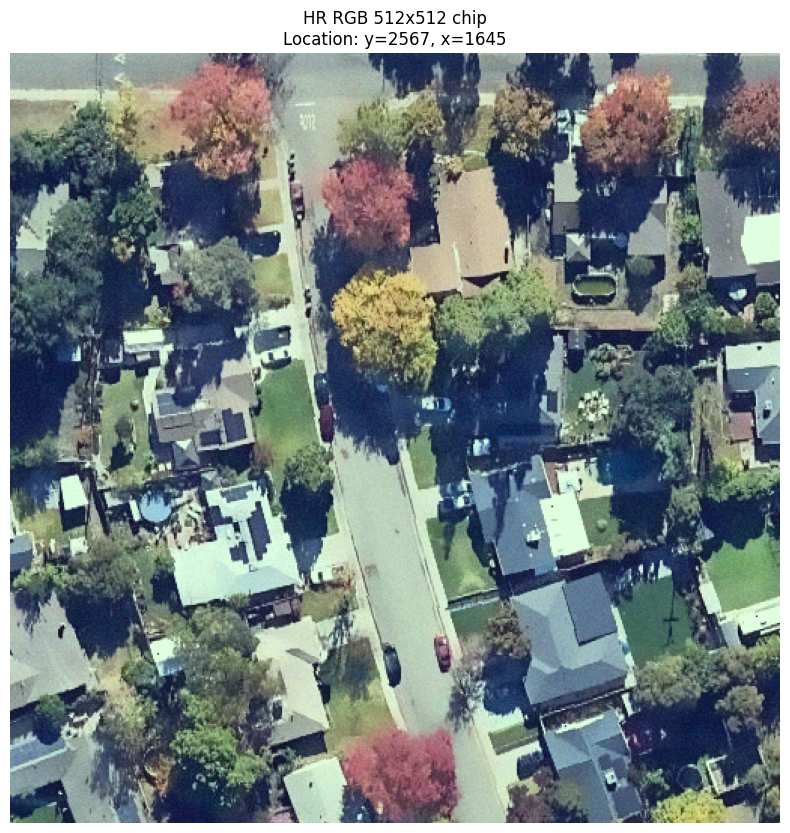

In [20]:
hr_chip = display_image_chip(tree)

Using sensor with data_vars: Data variables:
    AOT      (time, y, x) float32 1MB 168.0 168.0 168.0 168.0 ... 90.0 90.0 90.0
    B01      (time, y, x) float32 1MB 1.212e+03 1.212e+03 ... 1.402e+03
    B02      (time, y, x) float32 1MB 1.194e+03 1.275e+03 ... 1.397e+03 1.59e+03
    B03      (time, y, x) float32 1MB 1.418e+03 1.507e+03 ... 1.939e+03
    B04      (time, y, x) float32 1MB 1.262e+03 1.324e+03 ... 2.124e+03
    B05      (time, y, x) float32 1MB 1.906e+03 1.89e+03 ... 2.108e+03 1.968e+03
    B06      (time, y, x) float32 1MB 3.497e+03 3.771e+03 ... 2.515e+03
    B07      (time, y, x) float32 1MB 4.377e+03 4.345e+03 ... 2.808e+03 2.63e+03
    B08      (time, y, x) float32 1MB 4.002e+03 4.396e+03 ... 2.832e+03
    B09      (time, y, x) float32 1MB 5.381e+03 5.381e+03 ... 3.17e+03 3.042e+03
    B11      (time, y, x) float32 1MB 3.111e+03 3.085e+03 ... 2.463e+03
    B12      (time, y, x) float32 1MB 2.039e+03 1.964e+03 ... 2.166e+03
    B8A      (time, y, x) float32 1MB 4.561e+0

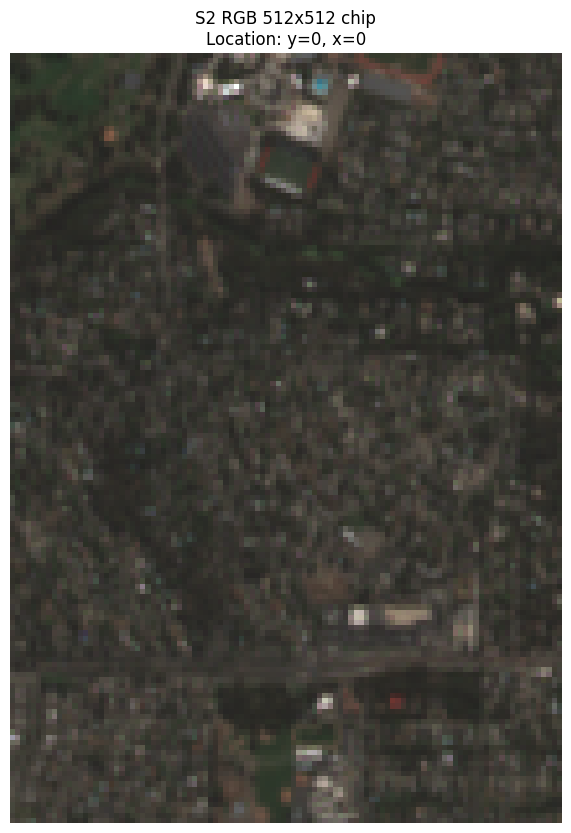

In [21]:
s2_chip = display_image_chip(tree, data_type='s2', combine_rgb_bands=True)

Using sensor with data_vars: Data variables:
    qa             (time, y, x) float32 280kB 289.0 290.0 289.0 ... 329.0 331.0
    red            (time, y, x) float32 280kB 9.383e+03 9.24e+03 ... 1.029e+04
    blue           (time, y, x) float32 280kB 9.107e+03 8.942e+03 ... 9.207e+03
    drad           (time, y, x) float32 280kB 928.0 928.0 928.0 ... 254.0 254.0
    emis           (time, y, x) float32 280kB 9.865e+03 9.863e+03 ... 9.789e+03
    emsd           (time, y, x) float32 280kB 49.0 58.0 58.0 ... 40.0 40.0 40.0
    trad           (time, y, x) float32 280kB 1.025e+04 1.029e+04 ... 8.857e+03
    urad           (time, y, x) float32 280kB 1.925e+03 1.925e+03 ... 458.0
    atran          (time, y, x) float32 280kB 7.725e+03 7.725e+03 ... 9.336e+03
    cdist          (time, y, x) float32 280kB 144.0 144.0 144.0 ... 100.0 98.0
    green          (time, y, x) float32 280kB 1.013e+04 1e+04 ... 1.023e+04
    nir08          (time, y, x) float32 280kB 2.3e+04 2.155e+04 ... 1.497e+04
    lwi

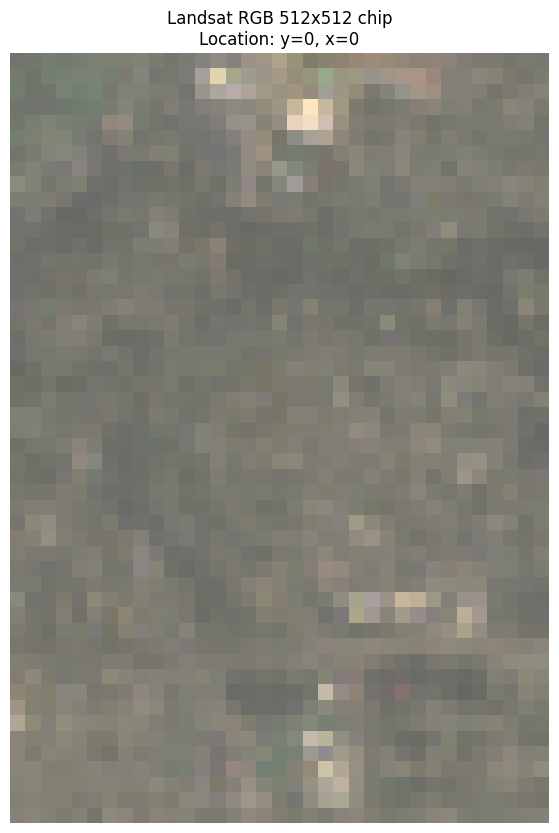

In [22]:
landsat_chip = display_image_chip(tree, data_type='landsat')

In [23]:
# display full tree hr image
import matplotlib.pyplot as plt
import numpy as np

def display_full_image(tree, data_type='hr', combine_rgb_bands=False):
    """
    Display full imagery from core-five datatree (supports both HR and Sentinel-2).
    
    Args:
        tree: xarray DataTree from core-five
        data_type: 'hr' for high-res RGB or 's2' for Sentinel-2
    
    Returns:
        image_rgb: numpy array of shape (height, width, 3)
    """

    # Pick latest time
    latest_time_idx = -1
    if data_type == 'hr':
        # HR data: shape is (band, y, x)
        hr_data = tree["hr/data"].values
        n_bands, height, width = hr_data.shape
        print(f"HR image shape: {hr_data.shape} (band, y, x)")

        # Transpose from (band, y, x) to (y, x, band) for matplotlib
        image_rgb = np.transpose(hr_data, (1, 2, 0))
        print(f"Image shape after transpose: {image_rgb.shape} (y, x, band)")
        
        title = "Full HR RGB Image"
        
    elif data_type == 's2':
        # S2 data: shape is (time, y, x) for each band
        s2_ds = tree['s2'].ds
        
        print(f"S2 time dimension: {len(s2_ds.time)} timestamps")
        print(f"Using latest timestamp: {s2_ds.time.values[latest_time_idx]}")
        
        # Check if 'visual' band exists
        if 'visual' in s2_ds.data_vars and not combine_rgb_bands:
            print("Using pre-computed 'visual' band")
            s2_data = s2_ds['visual'].isel(time=latest_time_idx).values
            
            # If single channel, convert to RGB
            if s2_data.ndim == 2:
                image_rgb = np.stack([s2_data, s2_data, s2_data], axis=-1)
            else:
                image_rgb = s2_data
        else:
            # Create RGB from B04 (Red), B03 (Green), B02 (Blue)
            print("Creating RGB from B04 (Red), B03 (Green), B02 (Blue)")
            b04 = s2_ds['B04'].isel(time=latest_time_idx).values  # Red
            b03 = s2_ds['B03'].isel(time=latest_time_idx).values  # Green
            b02 = s2_ds['B02'].isel(time=latest_time_idx).values  # Blue
            
            image_rgb = np.stack([b04, b03, b02], axis=-1)
        
        print(f"S2 image shape: {image_rgb.shape} (y, x, band)")
        title = "Full S2 RGB Image"
    
    elif data_type == 'landsat':

        landsat_ds = tree['landsat'].ds
        print(f"Landsat time dimension: {len(landsat_ds.time)} timestamps")
        print(f"Using latest timestamp: {landsat_ds.time.values[latest_time_idx]}")

        print("Composing RGB from Landsat red, blue, and green bands...")

        red = landsat_ds['red'].isel(time=latest_time_idx).values
        green = landsat_ds['green'].isel(time=latest_time_idx).values
        blue = landsat_ds['blue'].isel(time=latest_time_idx).values
        image_rgb = np.stack([red, green, blue], axis=-1)

        print(f"Landsat image shape: {image_rgb.shape} (y, x, band)")
        title = "Full Landsat RGB Image"

        # Normalize to 0-1 range if needed
        if image_rgb.max() > 1.0:
            image_rgb = image_rgb / image_rgb.max()

        print(f"Image shape: {image_rgb.shape} (y, x, band)")
        title = "Full Landsat RGB Image"
    
    else:
        raise ValueError(f"Unknown data_type: {data_type}. Use 'hr' or 's2'.")

    # Normalize to 0-1 range if needed
    if image_rgb.max() > 1.0:
        image_rgb = image_rgb / image_rgb.max()
        print("Normalized image to 0-1 range")

    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

    return image_rgb

HR image shape: (3, 6279, 4453) (band, y, x)
Image shape after transpose: (6279, 4453, 3) (y, x, band)
Normalized image to 0-1 range


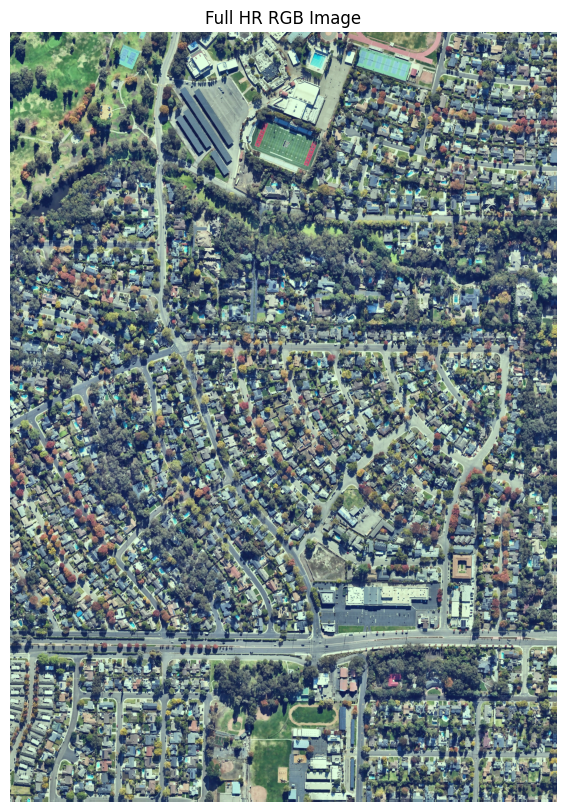

In [24]:
hr_full = display_full_image(tree)

S2 time dimension: 23 timestamps
Using latest timestamp: 2023-10-26T18:54:51.024000000
Creating RGB from B04 (Red), B03 (Green), B02 (Blue)
S2 image shape: (148, 106, 3) (y, x, band)
Normalized image to 0-1 range


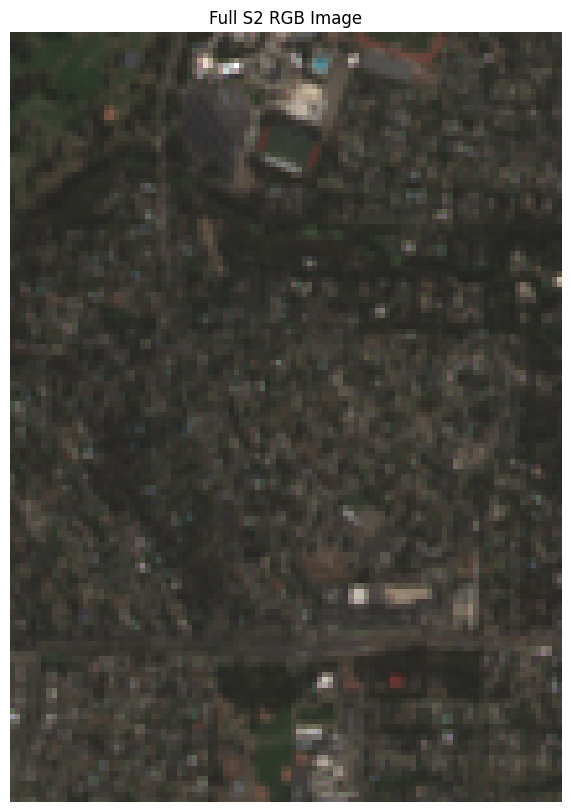

In [25]:
s2_full = display_full_image(tree, data_type='s2', combine_rgb_bands=True)

Landsat time dimension: 40 timestamps
Using latest timestamp: 2023-10-30T18:40:07.009071000
Composing RGB from Landsat red, blue, and green bands...
Landsat image shape: (50, 35, 3) (y, x, band)
Image shape: (50, 35, 3) (y, x, band)


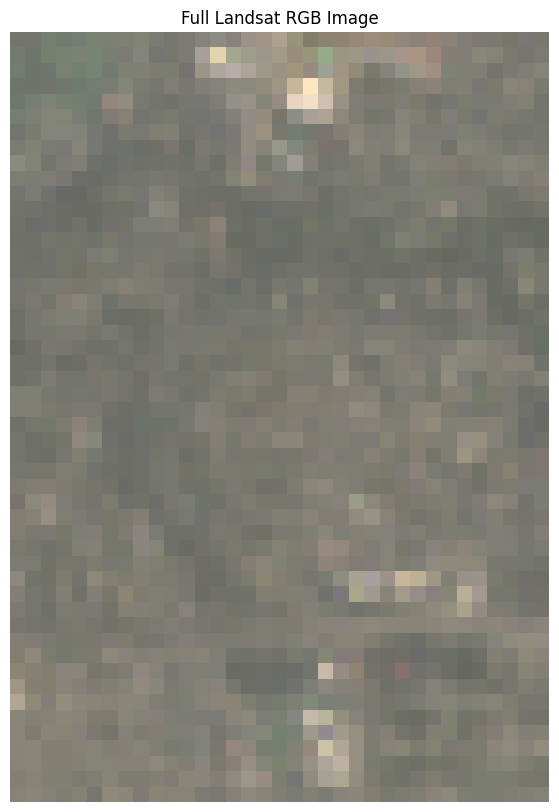

In [26]:
landsat_full = display_full_image(tree, data_type='landsat')

### Next Steps for Full Implementation

1. **Scale S2 parsing**: Process all parent directories in core-five (not just first 100)
2. **Optimize matching**: Use spatial indexing for faster PV-to-core-five matching
3. **Implement buffering**: Add 100m buffer around PV labels for chip extraction
4. **Set up VirtualiZarr caching**: Configure local storage with virtualizarr for efficient subset retrieval
5. **Integrate SAM 2**: Add segmentation mask generation using box prompts
6. **Persist to Lance**: Store chips, masks, and metadata in Lance datasets

**Key Insights from MVP:**
- S2 cell levels in core-five dataset: [to be determined from actual run]
- Match rate: [to be determined from actual run]
- URL format for HuggingFace dataset access needs validation

## Step 6: Image Chipping with Bounding Boxes

**Goal**: Create a chipping function that:
1. Takes the full HR RGB image
2. Chips it to a given size in pixels
3. Uses level 19 S2 cells to draw bounding boxes
4. Saves the list of bounding boxes for SAM prompts

**Purpose**: Determine if level 19 S2 cells (~15m) are good enough for SAM box prompts,
or if we need to use actual Polygon PV labels (which would reduce matches since many labels are Points).

In [27]:
# Helper functions for converting geometries to bounding boxes for SAM
import s2cell
from shapely.geometry import box
import geopandas as gpd

def geometry_to_bbox_coords(geometry, chip_size=512, chip_xy=None):
    """
    Convert a Shapely geometry to bbox coordinates for SAM.
    
    Args:
        geometry: Shapely geometry (Point, Polygon, etc.)
    
    Returns:
        list: [left, bottom, right, top] in geometry's CRS
    """
    bounds = geometry.bounds  # (minx, miny, maxx, maxy)
    return [bounds[0], bounds[1], bounds[2], bounds[3]]

def s2_cell_to_bbox_coords(s2_cell_id, buffer_m=15):
    """
    Convert an S2 cell ID to bbox coordinates for SAM.
    
    Args:
        s2_cell_id: S2 cell ID (int)
        buffer_m: Buffer size in meters (default 15m for level 19)
    
    Returns:
        list: [left, bottom, right, top] in EPSG:4326
    """
    # Get S2 cell center in lat/lon
    lat, lon = s2cell.cell_id_to_lat_lon(s2_cell_id)
    
    # Approximate degrees per meter at this latitude
    # TODO: use duckdb geography extension in pipelines when 1.4 support is available
    import math
    deg_per_m_lat = 1 / 111000
    deg_per_m_lon = 1 / (111000 * math.cos(math.radians(lat)))
    
    # Create bbox
    half_buffer_lat = buffer_m * deg_per_m_lat
    half_buffer_lon = buffer_m * deg_per_m_lon
    
    return [
        lon - half_buffer_lon,  # left
        lat - half_buffer_lat,  # bottom
        lon + half_buffer_lon,  # right
        lat + half_buffer_lat   # top
    ]

def collect_bboxes_for_sam(pv_labels, use_s2_cells=False):
    """
    Collect bounding boxes from PV labels for SAM prompts.
    
    Args:
        pv_labels: GeoDataFrame with PV labels
        use_s2_cells: If True, use S2 cells; otherwise use geometry bounds
    
    Returns:
        list: List of bbox coordinates [[left, bottom, right, top], ...]
    """
    bboxes = []
    
    for idx, row in pv_labels.iterrows():
        if use_s2_cells and 's2_cell_lvl_19' in row:
            bbox = s2_cell_to_bbox_coords(row['s2_cell_lvl_19'])
        else:
            bbox = geometry_to_bbox_coords(row.geometry)
        
        bboxes.append(bbox)
    
    return bboxes

In [ ]:
# Pixel coordinate conversion functions with CRS transformation
# Copy this entire cell into your notebook to replace the existing pixel_bbox_converters cell

from affine import Affine
from pyproj import Transformer

def get_transform_from_coords(x_coords, y_coords):
    """
    Calculate affine transform from xarray coordinates.
    
    Args:
        x_coords: xarray x coordinates (in projected units, e.g., meters)
        y_coords: xarray y coordinates (in projected units, e.g., meters)
    
    Returns:
        Affine: Affine transform object
    
    Example:
        >>> transform = get_transform_from_coords(tree['hr'].ds.x, tree['hr'].ds.y)
    """
    # Calculate pixel size from coordinate spacing
    pixel_width = double(x_coords[1] - x_coords[0])
    pixel_height = double(y_coords[1] - y_coords[0])
    
    # Upper-left corner (coords are pixel centers)
    x_min = double(x_coords[0]) - pixel_width / 2
    y_max = double(y_coords[0]) - pixel_height / 2
    
    # Create affine transform
    transform = Affine(pixel_width, 0.0, x_min,
                      0.0, pixel_height, y_max)
    
    print(f"✓ Transform: pixel_width={pixel_width:.6f}m, pixel_height={pixel_height:.6f}m")
    return transform

def geo_to_pixel_coords(lon, lat, transform, src_crs='EPSG:4326', dst_crs=None):
    """
    Convert geographic coordinates to pixel coordinates.
    
    Args:
        lon: Longitude in degrees (or x in projected units if src_crs matches image)
        lat: Latitude in degrees (or y in projected units if src_crs matches image)
        transform: Affine transform from get_transform_from_coords()
        src_crs: Source CRS (default 'EPSG:4326' for lat/lon)
        dst_crs: Destination CRS (e.g., 'EPSG:32630' for UTM 30N). If None, no transformation.
    
    Returns:
        tuple: (col, row) pixel coordinates
    """
    # Transform to image CRS if needed
    if dst_crs is not None and src_crs != dst_crs:
        transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
        x, y = transformer.transform(lon, lat)
    else:
        x, y = lon, lat
    
    # Convert to pixel coordinates
    inv_transform = transform
    col, row = inv_transform * (x, y)
    return int(col), int(row)

def geometry_to_bbox_pixels(geometry, transform, src_crs='EPSG:4326', dst_crs=None):
    """
    Convert a Shapely geometry to pixel bbox coordinates.
    
    Args:
        geometry: Shapely geometry in src_crs
        transform: Affine transform from get_transform_from_coords()
        src_crs: Source CRS of geometry (default 'EPSG:4326')
        dst_crs: Image CRS. If None, assumes geometry already in image CRS.
    
    Returns:
        tuple: (x_min, y_min, x_max, y_max) in pixel coordinates
    """
    minx, miny, maxx, maxy = geometry.bounds
    
    # Convert corners to pixel coordinates
    x_min, y_max_px = geo_to_pixel_coords(minx, maxy, transform, src_crs, dst_crs)
    x_max, y_min_px = geo_to_pixel_coords(maxx, miny, transform, src_crs, dst_crs)
    
    return (x_min, y_min_px, x_max, y_max_px)

def s2_cell_to_bbox_pixels(s2_cell_id, transform, dst_crs=None, buffer_m=15):
    """
    Convert an S2 cell ID to pixel bbox coordinates.
    
    Args:
        s2_cell_id: S2 cell ID (int)
        transform: Affine transform from get_transform_from_coords()
        dst_crs: Image CRS. If None, no transformation.
        buffer_m: Buffer size in meters (default 15m for level 19)
    
    Returns:
        tuple: (x_min, y_min, x_max, y_max) in pixel coordinates
    """
    import s2cell
    import math
    
    # Get S2 cell center in lat/lon
    lat, lon = s2cell.cell_id_to_lat_lon(s2_cell_id)
    
    # Approximate degrees per meter at this latitude
    # TODO: convert to use duckdb geography which has function for this https://github.com/paleolimbot/duckdb-geography/blob/main/docs/function-reference.md 
    deg_per_m_lat = 1 / 111000
    deg_per_m_lon = 1 / (111000 * math.cos(math.radians(lat)))
    
    # Create geographic bbox
    half_buffer_lat = buffer_m * deg_per_m_lat
    half_buffer_lon = buffer_m * deg_per_m_lon
    
    minx = lon - half_buffer_lon
    miny = lat - half_buffer_lat
    maxx = lon + half_buffer_lon
    maxy = lat + half_buffer_lat
    
    # Convert to pixel coordinates
    x_min, y_max_px = geo_to_pixel_coords(minx, maxy, transform, 'EPSG:4326', dst_crs)
    x_max, y_min_px = geo_to_pixel_coords(maxx, miny, transform, 'EPSG:4326', dst_crs)
    
    return (x_min, y_min_px, x_max, y_max_px)

print("✓ Pixel coordinate converters ready (with CRS transformation)")
print("  - get_transform_from_coords(): Calculate transform from xarray coords")
print("  - geo_to_pixel_coords(): Convert lon/lat to pixel col/row")
print("  - geometry_to_bbox_pixels(): Convert geometry to pixel bbox")
print("  - s2_cell_to_bbox_pixels(): Convert S2 cell to pixel bbox")

✓ Pixel coordinate converters ready (with CRS transformation)
  - get_transform_from_coords(): Calculate transform from xarray coords
  - geo_to_pixel_coords(): Convert lon/lat to pixel col/row
  - geometry_to_bbox_pixels(): Convert geometry to pixel bbox
  - s2_cell_to_bbox_pixels(): Convert S2 cell to pixel bbox


In [38]:
# plot out our bbox in pixel coordinates on the hr_data image
def plot_bbox_on_image(image, bbox, color='red'):
    """
    Plot a bounding box on an image.
    
    Args:
        image: numpy array of shape (height, width, 3)
        bbox: tuple of (x_min, y_min, x_max, y_max) in pixel coordinates
        color: color of the bounding box
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor=color, facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

Sample S2 cell geom: [-121.3374469646127, 38.01455130707002, -121.33710391800543, 38.014821577340285]
✓ Transform: pixel_width=0.248823m, pixel_height=0.248823m
Sample S2 cell bbox: (-783463, 7045288, -783449, 7045303)


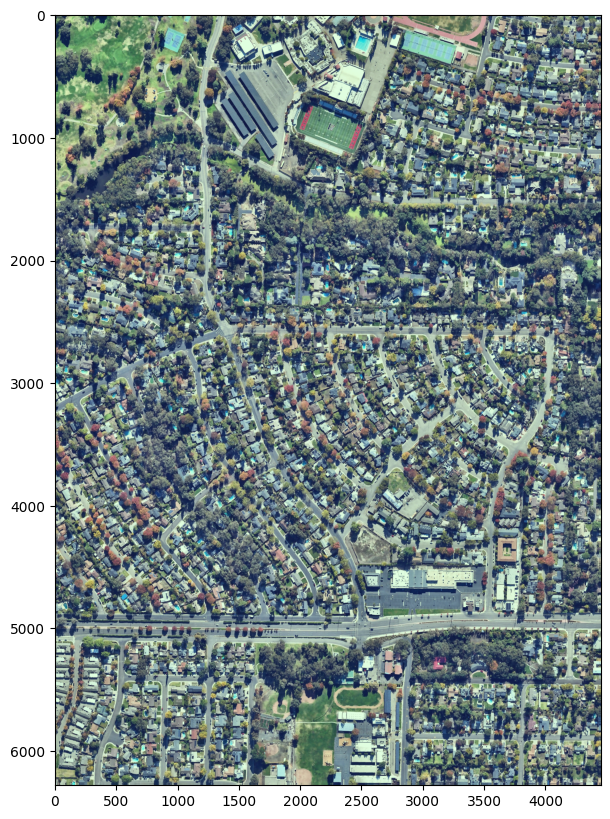

In [36]:
sample_pv_label = pv_gdf[pv_gdf['num_matches'] > 0].iloc[rand_sample_idx]
sample_s2_cell = sample_pv_label['s2_cell_lvl_19']
# cast to int
sample_s2_cell = int(sample_s2_cell)
sample_s2_geom = s2_cell_to_bbox_coords(sample_s2_cell)
print(f"Sample S2 cell geom: {sample_s2_geom}")
# convert list of coords to geometry
sample_s2_geom = box(*sample_s2_geom)
# need to project to image crs
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)
sample_s2_geom = shapely.ops.transform(transformer.transform, sample_s2_geom)
sample_geotransform = get_transform_from_coords(tree["hr"].ds.x, tree["hr"].ds.y)
sample_s2_bbox = geometry_to_bbox_pixels(sample_s2_geom, sample_geotransform)
print(f"Sample S2 cell bbox: {sample_s2_bbox}")
plot_bbox_on_image(hr_full, sample_s2_bbox)

Sample PV bbox: [-121.33725174553962, 38.014682751085715, -121.33715954941258, 38.01474725461901]


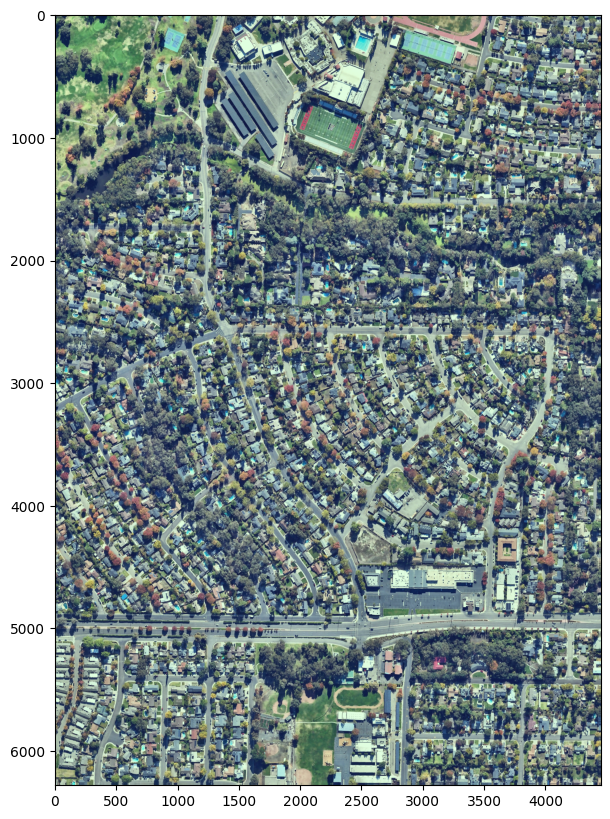

In [ ]:
if sample_pv_label.geometry.geom_type == 'Polygon':
    sample_pv_bbox = geometry_to_bbox_coords(sample_pv_label.geometry, sample_geotransform)
    print(f"Sample PV bbox: {sample_pv_bbox}")
    plot_bbox_on_image(hr_full, sample_pv_bbox, color='green')

## Step 7: SAM Integration

**Goal**: Test SAM segmentation with our matched PV labels and imagery.

**References**:
- [Box prompts](https://samgeo.gishub.org/examples/box_prompts/)
- [SAM2 box prompts](https://samgeo.gishub.org/examples/sam2_box_prompts/)
- [Text prompts](https://samgeo.gishub.org/examples/text_prompts/)

### 7A: SAM2 with Box Prompts (Recommended)

Using level 19 S2 cells or PV polygon geometries as box prompts.

In [33]:
# SAM2 with Box Prompts - Using our matched data
from samgeo import SamGeo2
from samgeo.common import raster_to_vector, regularize
import numpy as np

# Sample a random PV label with matches
matched_pv = pv_gdf[pv_gdf['num_matches'] > 0]
sample_idx = np.random.randint(0, len(matched_pv))
sample_label = matched_pv.iloc[sample_idx]

print(f"Sampled PV label {sample_idx}:")
print(f"  Geometry type: {sample_label.geometry.geom_type}")
print(f"  Matched files: {sample_label['num_matches']}")
print(f"  S2 cell (lvl 19): {sample_label['s2_cell_lvl_19']}")

# Load the matched image
sample_file = sample_label['matched_files'][0]
filename = "/".join(Path(sample_file).parts[3:])
url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"

print(f"\nLoading image: {filename}")

# Load image with fsspec
import fsspec
import xarray as xr

with fsspec.open(url, 'rb') as f:
    tree = xr.open_datatree(f, engine='h5netcdf')
    tree.load()

# Extract HR RGB data
hr_data = tree["hr"]["data"].values
hr_rgb = np.transpose(hr_data, (1, 2, 0))  # (band, y, x) -> (y, x, band)

# Normalize to [0, 1]
if hr_rgb.max() > 1.0:
    hr_rgb = hr_rgb / hr_rgb.max()

print(f"Image shape: {hr_rgb.shape}")

# Create bounding boxes from geometry
# Option 1: Use PV geometry directly (if Polygon)
# Option 2: Use level 19 S2 cell

if sample_label.geometry.geom_type == 'Polygon':
    # Use actual PV polygon bounds
    bounds = sample_label.geometry.bounds  # (minx, miny, maxx, maxy)
    boxes = [[bounds[0], bounds[1], bounds[2], bounds[3]]]  # [left, bottom, right, top]
    print(f"\nUsing Polygon geometry as box prompt")
else:
    # Use S2 cell or buffer Point geometry
    # For now, use S2 cell bounds (approximate)
    centroid = sample_label['centroid']
    cell_size_deg = 0.0002  # ~15m at equator
    boxes = [[
        centroid.x - cell_size_deg/2,
        centroid.y - cell_size_deg/2,
        centroid.x + cell_size_deg/2,
        centroid.y + cell_size_deg/2
    ]]
    print(f"\nUsing S2 cell (level 19) as box prompt")

print(f"Box prompt (lat/lon): {boxes}")

# Initialize SAM2
print(f"\nInitializing SAM2...")
sam = SamGeo2(
    model_id="sam2-hiera-tiny",
    automatic=False,
    device="cpu"  # Change to "cuda" if GPU available
    # mps is not compatible due to: "Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64."
)

# Set image
sam.set_image(hr_rgb)

# Predict with box prompts
output_path = "../data/sam2_box_mask.tif"
print(f"\nRunning SAM2 prediction...")

sam.predict(
    boxes=boxes,
    point_crs="EPSG:4326",
    output=output_path,
    dtype="uint8",
    multimask_output=False
)

print(f"✓ Mask saved to: {output_path}")

# Convert to vector
vector_path = "../data/sam2_box_vector.geojson"
raster_to_vector(output_path, vector_path)
print(f"✓ Vector saved to: {vector_path}")

# Visualize
sam.show_anns(cmap="Greens", box_color="red", blend=True)

Sampled PV label 127:
  Geometry type: Polygon
  Matched files: 1
  S2 cell (lvl 19): 3877306622640390144

Loading image: src/datatree/35cef5/35cef5d4.nc
Image shape: (5952, 4510, 3)

Using Polygon geometry as box prompt
Box prompt (lat/lon): [[116.4647067628384, 33.37166353310844, 116.46538669285795, 33.37265815259569]]

Initializing SAM2...


RuntimeError: Input type (double) and bias type (float) should be the same

### 7B: LangSAM with Text Prompts

Using text prompt "solar panel" to detect PV installations.

In [ ]:
# LangSAM with Text Prompts - Using our matched data
from samgeo.text_sam import LangSAM

# Use the same sampled image from above
print(f"Using same image: {filename}")
print(f"Image shape: {hr_rgb.shape}")

# Initialize LangSAM
print(f"\nInitializing LangSAM...")
sam_text = LangSAM()

# Text prompt
text_prompt = "solar panel"
print(f"Text prompt: '{text_prompt}'")

# Predict
output_path_text = "../data/langsam_text_mask.tif"
print(f"\nRunning LangSAM prediction...")

sam_text.predict(
    hr_rgb,
    text_prompt,
    box_threshold=0.24,  # Object detection confidence
    text_threshold=0.24,  # Text-object association confidence
    output=output_path_text
)

print(f"✓ Mask saved to: {output_path_text}")

# Convert to vector
vector_path_text = "../data/langsam_text_vector.geojson"
sam_text.raster_to_vector(output_path_text, vector_path_text)
print(f"✓ Vector saved to: {vector_path_text}")

# Visualize
sam_text.show_anns(cmap="Greens", box_color="red", blend=True)

### 7C: Compare Results

Compare SAM2 box prompts vs LangSAM text prompts.

In [ ]:
# Compare SAM2 box prompts vs LangSAM text prompts
import matplotlib.pyplot as plt
import rasterio

# Load masks
with rasterio.open("../data/sam2_box_mask.tif") as src:
    sam2_mask = src.read(1)

with rasterio.open("../data/langsam_text_mask.tif") as src:
    langsam_mask = src.read(1)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(hr_rgb)
axes[0].set_title("Original HR RGB")
axes[0].axis('off')

# SAM2 box prompts
axes[1].imshow(hr_rgb)
axes[1].imshow(sam2_mask, alpha=0.5, cmap='Greens')
axes[1].set_title("SAM2 (Box Prompts)")
axes[1].axis('off')

# LangSAM text prompts
axes[2].imshow(hr_rgb)
axes[2].imshow(langsam_mask, alpha=0.5, cmap='Blues')
axes[2].set_title("LangSAM (Text Prompts)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nMask Statistics:")
print(f"  SAM2 (box): {sam2_mask.sum()} pixels segmented")
print(f"  LangSAM (text): {langsam_mask.sum()} pixels segmented")
print(f"  Overlap: {(sam2_mask & langsam_mask).sum()} pixels")

### VirtualiZarr

#### OPTION 2A: VirtualiZarr with HTTP Store + Authentication ✅

In [ ]:

# Based on:
#   - VirtualiZarr docs: https://virtualizarr.readthedocs.io/en/stable/usage.html
#   - obstore ClientConfig: https://developmentseed.org/obstore/latest/api/store/config/
# Using HTTPStore with client_options={'default_headers': {'Authorization': 'Bearer ...'}}

from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
from obstore.store import HTTPStore

# Get HuggingFace token from environment
hf_token = os.getenv('HF_TOKEN')

if not hf_token:
    print("WARNING: HF_TOKEN not found in environment.")
    print("VirtualiZarr may fail with 401 Unauthorized for private datasets.")
    print("Set HF_TOKEN in your .env file for authenticated access.")
else:
    print("✓ HF_TOKEN found - using authenticated access")

if (pv_gdf['num_matches'] > 0).sum() > 0:
    sample_file = pv_gdf[pv_gdf['num_matches'] > 0].iloc[rand_sample_idx]['matched_files'][0]
    filename = "/".join(Path(sample_file).parts[3:])
    url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"
    
    print(f"\nVirtualizing file: {filename}")
    print(f"URL: {url}")
    
    try:
        # Create HTTP store with authentication
        # ClientConfig.default_headers accepts dict[str, str] | dict[str, bytes]
        bucket = "https://huggingface.co"
        
        # Create HTTPStore with authentication headers via client_options
        if hf_token:
            # HTTPStore with Bearer token authentication
            # This is the CORRECT way per obstore docs
            store = HTTPStore.from_url(
                bucket,
                client_options={
                    'default_headers': {
                        'Authorization': f'Bearer {hf_token}'
                    }
                }
            )
        else:
            # HTTPStore without authentication (for public datasets)
            store = HTTPStore.from_url(bucket)
        
        registry = ObjectStoreRegistry({bucket: store})
        
        # Open as virtual dataset
        print("Creating virtual dataset...")
        vds = open_virtual_dataset(
            url=url,
            registry=registry,
            parser=HDFParser(),
            loadable_variables=['time', 'x', 'y'],  # Load coords, virtualize data
            decode_times=True  # Decode CF time variables
        )
        
        print(f"\n✓ Virtual dataset created!")
        print(f"  Variables: {list(vds.data_vars)}")
        print(f"  Coordinates: {list(vds.coords)}")
        print(f"  Dimensions: {dict(vds.dims)}")
        print(f"\nMemory footprint (virtual refs only): {vds.vz.nbytes / 1024**2:.2f} MB")
        print(f"Actual data size (if loaded): {vds.nbytes / 1024**2:.2f} MB")
        
        # Show what's virtual vs loaded
        print(f"\nData variables (virtualized):")
        for var in vds.data_vars:
            print(f"  - {var}: {vds[var].shape}")
        
        print(f"\nCoordinates (loaded into memory):")
        for coord in vds.coords:
            print(f"  - {coord}: {vds[coord].shape}")
        
    except Exception as e:
        print(f"\nError: {e}")
        print(f"\nTroubleshooting:")
        print(f"1. Check if HF_TOKEN is set correctly in .env")
        print(f"2. Verify token has access to gajeshladhar/core-five dataset")
        print(f"3. Try accessing URL directly in browser to test authentication")
        import traceback
        traceback.print_exc()
else:
    print("No matches found.")

#### OPTION 2B: VirtualiZarr - Multiple Files (COMMENTED OUT - For Future E2E Pipelines)

**Note**: This approach is premature for the current notebook's depth-first workflow.

**Issue**: Fails with `ValueError: Could not find any dimension coordinates` due to:
- Different coordinate orders between `/hr` and `/s2` groups
- `spatial_ref` being a data variable instead of coordinate in `/s2`

**Future Use**: Ideal for E2E pipelines:
- Virtualize datasets → store as Icechunk/Kerchunk parquet in R2
- Materialize images at runtime with Lance or in-memory format

**Commented out for now** - see OPTION 2C below for single-group virtualization approach.

In [ ]:
# COMMENTED OUT - See markdown above for reasoning
# Uncomment for future E2E pipeline work

# from virtualizarr import open_virtual_mfdataset
# from virtualizarr.parsers import HDFParser
# from virtualizarr.registry import ObjectStoreRegistry
# from obstore.store import HTTPStore

# # Get HuggingFace token from environment
# hf_token = os.getenv('HF_TOKEN')
# 
# if not hf_token:
#     print("WARNING: HF_TOKEN not found in environment.")
#     print("Set HF_TOKEN in your .env file for authenticated access.")
# else:
#     print("✓ HF_TOKEN found - using authenticated access")
# 
# # ... rest of code commented out ...
# # See git history or uncomment for future E2E pipeline work

pass  # Placeholder to keep cell valid

#### OPTION 2C: VirtualiZarr - Single DataTree Group (Experimental)

**Exploring**: Can we virtualize individual groups from a DataTree?

**Approach**: Extract a single group (e.g., `/hr` or `/s2`) as an xarray Dataset, then virtualize it.

**Goal**: Get a manageable "feel" for loading and saving virtual datasets before scaling up.

In [ ]:
# OPTION 2C: Virtualize a single DataTree group
# Test: Can we use VirtualiZarr to virtualize a specific group from the NetCDF file?
# Approach: Use open_virtual_dataset with group parameter (if supported)

import xarray as xr
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
from obstore.store import HTTPStore

# Get HuggingFace token
hf_token = os.getenv('HF_TOKEN')

if not hf_token:
    print("WARNING: HF_TOKEN not found")
else:
    print("✓ HF_TOKEN found")

if (pv_gdf['num_matches'] > 0).sum() > 0:
    sample_file = pv_gdf[pv_gdf['num_matches'] > 0].iloc[rand_sample_idx]['matched_files'][0]
    filename = "/".join(Path(sample_file).parts[3:])
    url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"
    
    print(f"\nFile: {filename}")
    print(f"URL: {url}")
    
    try:
        # Create HTTP store with authentication
        bucket = "https://huggingface.co"
        
        if hf_token:
            store = HTTPStore.from_url(
                bucket,
                client_options={
                    'default_headers': {
                        'Authorization': f'Bearer {hf_token}'
                    }
                }
            )
        else:
            store = HTTPStore.from_url(bucket)
        
        registry = ObjectStoreRegistry({bucket: store})
        
        # Test 1: Can we virtualize a specific HDF5 group?
        # NetCDF4 files are HDF5 files with groups like /hr/data and /s2
        print(f"\n--- Test 1: Virtualizing /hr/data group ---")
        
        # HDFParser might support group parameter
        # Let's try passing group to the parser
        try:
            vds_hr = open_virtual_dataset(
                url=url,
                registry=registry,
                parser=HDFParser(group='/hr/data'),  # Try specifying group
                loadable_variables=['x', 'y', 'band'],
                decode_times=False
            )
            
            print(f"✓ Virtualized /hr/data group!")
            print(f"  Variables: {list(vds_hr.data_vars)}")
            print(f"  Coordinates: {list(vds_hr.coords)}")
            print(f"  Dimensions: {dict(vds_hr.dims)}")
            print(f"  Virtual size: {vds_hr.vz.nbytes / 1024**2:.2f} MB")
            print(f"  Actual size: {vds_hr.nbytes / 1024**2:.2f} MB")
            
        except TypeError as e:
            if 'group' in str(e):
                print(f"✗ HDFParser doesn't support 'group' parameter")
                print(f"  Error: {e}")
                
                # Test 2: Virtualize the whole file, then extract group
                print(f"\n--- Test 2: Virtualize whole file, extract group later ---")
                
                vds_full = open_virtual_dataset(
                    url=url,
                    registry=registry,
                    parser=HDFParser(),
                    loadable_variables=['x', 'y', 'time'],
                    decode_times=True
                )
                
                print(f"✓ Virtualized full file")
                print(f"  Variables: {list(vds_full.data_vars)}")
                print(f"  Coordinates: {list(vds_full.coords)}")
                
                # Check if we can access groups from the virtual dataset
                print(f"\n  Note: VirtualiZarr returns a flat xarray.Dataset")
                print(f"  It doesn't preserve HDF5 group hierarchy")
                print(f"  All variables from all groups are flattened into one Dataset")
            else:
                raise
        
        # Conclusion
        print(f"\n--- Conclusion ---")
        print(f"VirtualiZarr flattens HDF5 groups into a single xarray.Dataset")
        print(f"For our workflow (single group at a time), direct xarray loading is simpler")
        
    except Exception as e:
        print(f"\nError: {e}")
        
        # Known issue: HDFParser doesn't support group parameter
        if "is not an HDF Group" in str(e):
            print(f"\n✗ Confirmed: HDFParser doesn't support reading specific HDF5 groups")
            print(f"  VirtualiZarr flattens all groups into a single Dataset")
            print(f"  For our workflow (one group at a time), direct xarray loading is better")
        else:
            import traceback
            traceback.print_exc()
else:
    print("No matches found.")

#### VirtualiZarr Findings

**What we tested**:
1. ✅ **Single file virtualization** (OPTION 2A) - Works with authentication
2. ⚠️ **Multiple file virtualization** (OPTION 2B) - Coordinate mismatch between groups
3. 🧪 **Single group virtualization** (OPTION 2C) - Testing if HDFParser supports group parameter

**Key findings**:
- VirtualiZarr **flattens HDF5 groups** into a single xarray.Dataset
- Doesn't preserve DataTree hierarchy (all groups merged)
- For working with **one group at a time** (our workflow), direct xarray loading is simpler

**For this notebook's depth-first workflow**:
- ✅ **Direct xarray loading** is the right approach
- ✅ Loads individual DataTree groups on-demand
- ✅ Simple, straightforward, works perfectly for SAM segmentation

**VirtualiZarr is better suited for**:
- 📦 E2E pipelines virtualizing thousands of files
- 💾 Storing references in Icechunk/Kerchunk for repeated access
- 🚀 Materializing data at runtime from virtual stores
- 🔄 When you need to work with the **entire file** (all groups), not individual groups

**Next**: Continue with image display and SAM segmentation workflow using direct xarray loading.